In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
DEVICE = 'cn'
SUBTRACT_IDLE = True

match DEVICE:
    case 'cn': IDLE = 4
    case 'fpga': IDLE = 53
    case 'laptop': IDLE = 3

path_math = f'scripts/{DEVICE}/math.csv'
path_sleepy = f'scripts/{DEVICE}/sleepy.csv'
path_matmul = f'scripts/{DEVICE}/matmul.csv'

In [18]:
def read_csv(path):
    df = pd.read_csv(path)
    df = df[df['dynamic'] == False]
    df.drop(['dynamic'], axis=1, inplace=True)

    df['W'] = df['energy'] / df['runtime']

    if SUBTRACT_IDLE:
        df['energy'] -= df['runtime'] * IDLE
        assert((df['energy'] > 0).all())

    real_max = df['runtime'] * df['threads']
    user_pct = df['usertime'] / real_max
    user_pct = user_pct.clip(upper=1.0)
    df['usertime'] /= df['threads']
    df['user-pct'] = user_pct
    df['energy-user'] = df['energy'] * user_pct

    df0 = df.copy()[df['busy'] == 0]
    return df, df0

In [22]:
df_math,   df_math0   = read_csv(path_math)
df_sleepy, df_sleepy0 = read_csv(path_sleepy)
df_matmul, df_matmul0 = read_csv(path_matmul)
df_math

,busy,threads,energy,runtime,usertime,W,user-pct,energy-user
0,1,1,1.950220,0.158851,0.317487,16.277017,1.000000,1.950220
1,1,2,1.946804,0.158891,0.158843,16.252418,0.999696,1.946211
2,1,3,1.939091,0.158889,0.105934,16.204036,0.666716,1.292823
3,1,4,1.944065,0.158890,0.079460,16.235268,0.500093,0.972213
4,1,5,1.944221,0.158894,0.063597,16.235975,0.400247,0.778170
...,...,...,...,...,...,...,...,...
235,15,12,0.710114,0.022951,0.027628,34.940736,1.000000,0.710114
236,15,13,0.715423,0.023178,0.025511,34.866917,1.000000,0.715423
237,15,14,0.714986,0.023008,0.023720,35.075770,1.000000,0.714986
238,15,15,0.717855,0.023117,0.022189,35.053626,0.959860,0.689041


In [20]:
df_math_speedup   = df_math.copy()
df_sleepy_speedup = df_sleepy.copy()
df_matmul_speedup = df_matmul.copy()

for col in df_math_speedup.columns[2:]:
    df_math_speedup[col]   = df_math_speedup[col].iloc[0]   / df_math_speedup[col]
    df_sleepy_speedup[col] = df_sleepy_speedup[col].iloc[0] / df_sleepy_speedup[col]
    df_matmul_speedup[col] = df_matmul_speedup[col].iloc[0] / df_matmul_speedup[col]

df_math_speedup0   = df_math_speedup[df_math_speedup['busy'] == 0]
df_sleepy_speedup0 = df_sleepy_speedup[df_sleepy_speedup['busy'] == 0]
df_matmul_speedup0 = df_matmul_speedup[df_matmul_speedup['busy'] == 0]

KeyError: 'x'

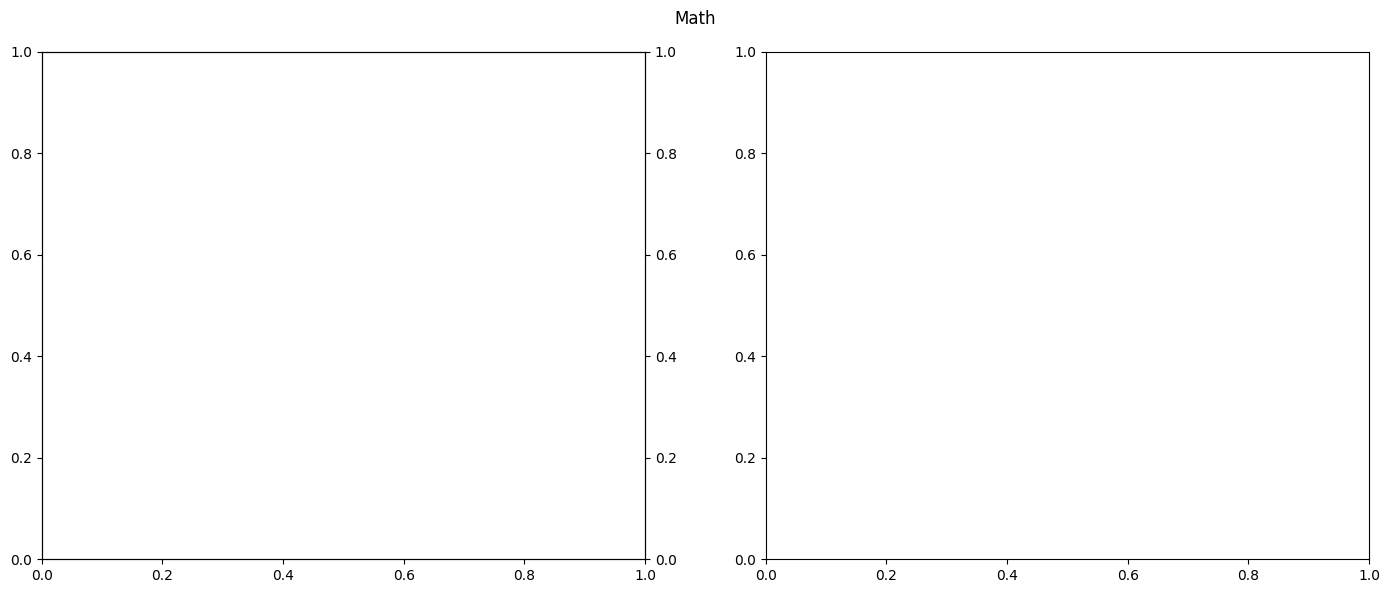

In [21]:
def plot(title, df0, df_speedup0):
    fig, (ax_energy1, ax_speedup) = plt.subplots(1, 2, figsize=(14,6))
    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)
    
    # Energy
    sns.barplot(df0, x='threads', y='energy', legend=False, color='cyan', ax=ax_energy1)
    sns.barplot(df0, x='threads', y='energy-user', legend=False, color='blue', ax=ax_energy1)
    ax_energy2 = ax_energy1.twinx()
    sns.lineplot(df0, x=df0.index, y='runtime', legend=False, color='r', ax=ax_energy2)
    sns.lineplot(df0, x=df0.index, y='usertime', legend=False, color='orange', ax=ax_energy2)

    ax_energy1.set_xlabel('#Threads')
    ax_energy1.set_ylabel('Energy (J)')
    ax_energy2.set_ylabel('Runtime (s)')
    ax_energy2.set_ylim((0, None))

    # Speedup
    sns.barplot(df_speedup0, x='threads', y='energy-user', label='Energy user', color='blue', ax=ax_speedup)
    sns.barplot(df_speedup0, x='threads', y='energy', label='Energy', color='cyan', ax=ax_speedup)
    sns.lineplot(df_speedup0, x=df_speedup0.index, y='runtime', label='Runtime', color='r', ax=ax_speedup)
    sns.lineplot(df_speedup0, x=df_speedup0.index, y='usertime', label='Usertime', color='orange', ax=ax_speedup)

    ax_speedup.set_xlabel('#Threads')
    ax_speedup.set_ylabel('Speedup')
    ax_speedup.set_ylim((0, None))

    plt.show()

plot('Math', df_math0, df_math_speedup0)
plot('Sleepy', df_sleepy0, df_sleepy_speedup0)
plot('Matmul', df_matmul0, df_matmul_speedup0)

# With busy threads

In [23]:
ENERGY = 'energy'

print('Math:')
for (busy, df_busy) in df_math.groupby('busy'):
    best = df_busy[df_busy[ENERGY] == df_busy[ENERGY].min()].iloc[0]
    threads = int(best['threads'])
    energy = best[ENERGY]
    print(f'{busy:2d} busy - Best: {threads:2d} threads @ {energy:.2f}J ({busy + threads} total workers)')

    r_best = df_busy[df_busy['runtime'] == df_busy['runtime'].min()].iloc[0]
    threads = int(r_best['threads'])
    runtime = r_best['runtime']
    print(f'          Best: {threads:2d} threads @ {runtime:.2f}s ({busy + threads} total workers)')

print()

print('Sleepy:')
for (busy, df_busy) in df_sleepy.groupby('busy'):
    best = df_busy[df_busy[ENERGY] == df_busy[ENERGY].min()].iloc[0]
    threads = int(best['threads'])
    energy = best[ENERGY]
    print(f'{busy:2d} busy - Best: {threads:2d} threads @ {energy:.2f}J ({busy + threads} total workers)')

print()

print('Matmul:')
for (busy, df_busy) in df_matmul.groupby('busy'):
    e_best = df_busy[df_busy[ENERGY] == df_busy[ENERGY].min()].iloc[0]
    threads = int(e_best['threads'])
    energy = e_best[ENERGY]
    print(f'{busy:2d} busy - Best: {threads:2d} threads @ {energy:.2f}J ({busy + threads} total workers)')

    r_best = df_busy[df_busy['runtime'] == df_busy['runtime'].min()].iloc[0]
    threads = int(r_best['threads'])
    runtime = r_best['runtime']
    print(f'          Best: {threads:2d} threads @ {runtime:.2f}s ({busy + threads} total workers)')

Math:
 1 busy - Best: 14 threads @ 1.83J (15 total workers)
          Best:  1 threads @ 0.16s (2 total workers)
 2 busy - Best: 14 threads @ 1.23J (16 total workers)
          Best:  3 threads @ 0.08s (5 total workers)
 3 busy - Best: 13 threads @ 1.09J (16 total workers)
          Best:  8 threads @ 0.06s (11 total workers)
 4 busy - Best: 11 threads @ 0.91J (15 total workers)
          Best:  4 threads @ 0.04s (8 total workers)
 5 busy - Best: 12 threads @ 0.85J (17 total workers)
          Best:  7 threads @ 0.03s (12 total workers)
 6 busy - Best: 10 threads @ 0.76J (16 total workers)
          Best:  8 threads @ 0.03s (14 total workers)
 7 busy - Best:  9 threads @ 0.71J (16 total workers)
          Best:  9 threads @ 0.02s (16 total workers)
 8 busy - Best:  8 threads @ 0.70J (16 total workers)
          Best:  8 threads @ 0.02s (16 total workers)
 9 busy - Best:  8 threads @ 0.68J (17 total workers)
          Best:  8 threads @ 0.02s (17 total workers)
10 busy - Best:  8 thread

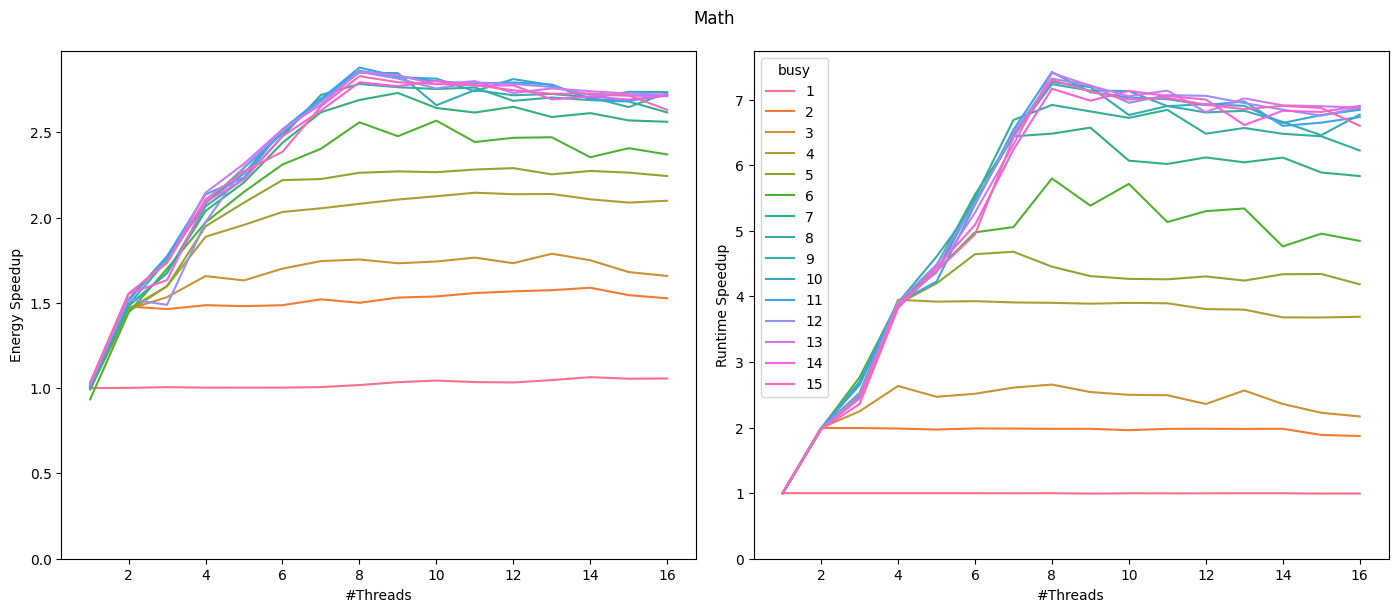

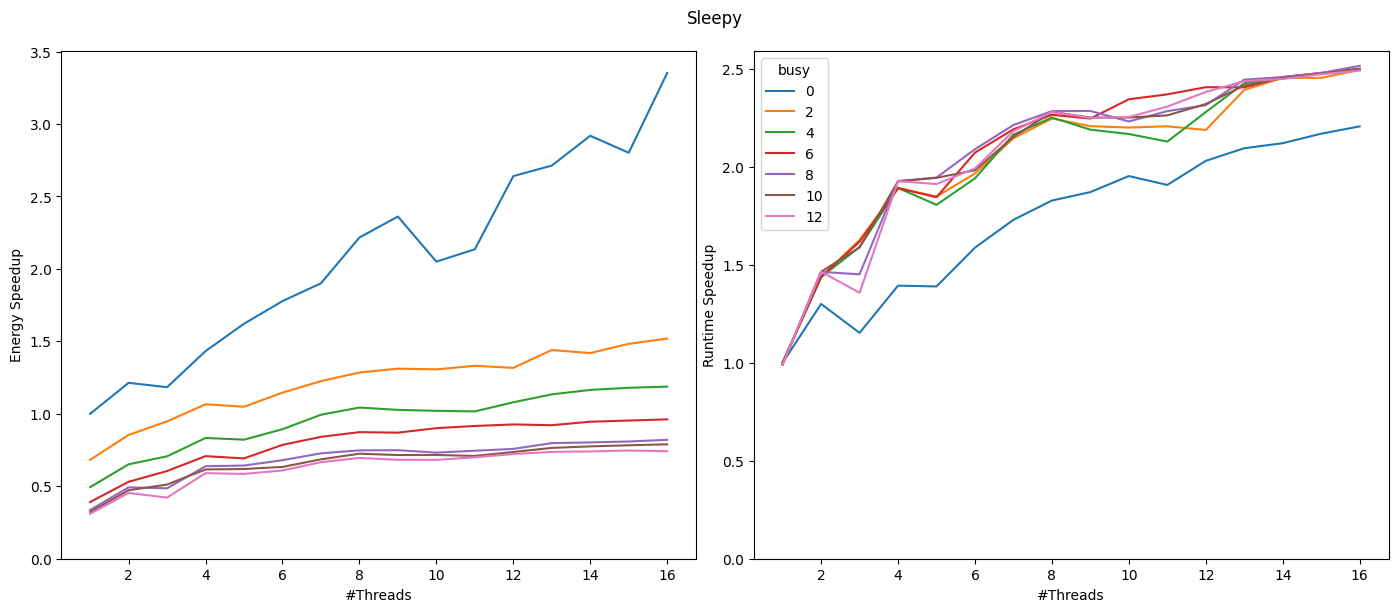

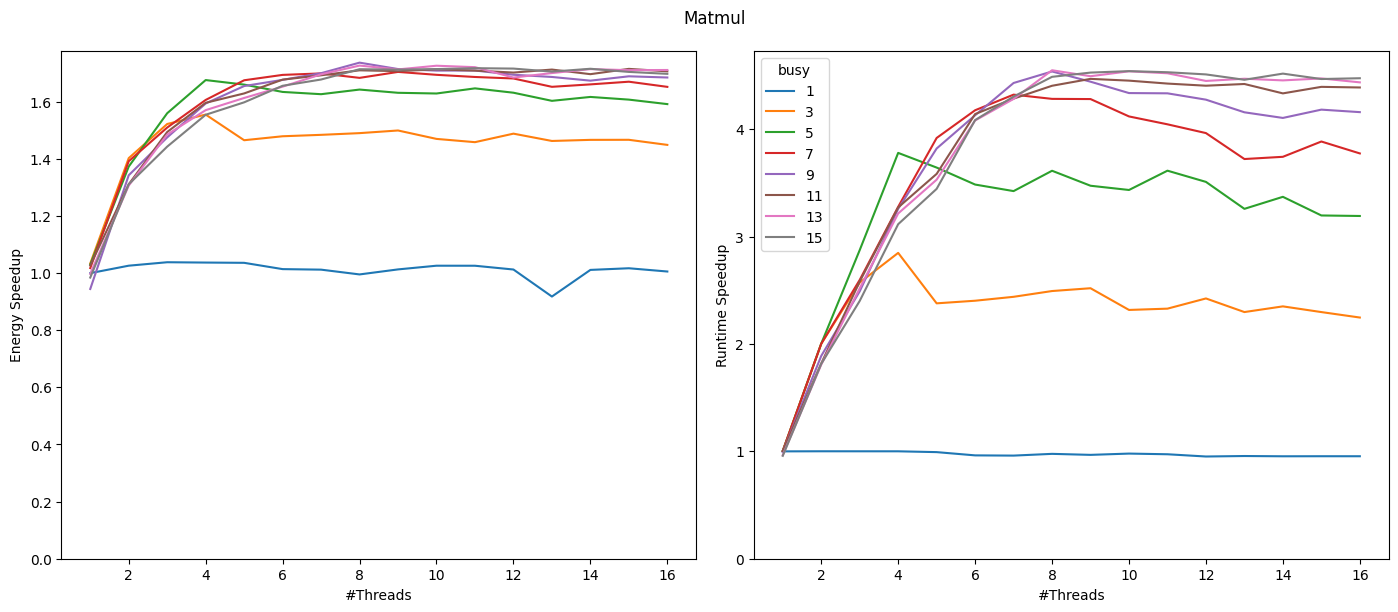

In [24]:
def plot(title, df):
    fig, (ax_energy, ax_runtime) = plt.subplots(1, 2, figsize=(14,6))
    fig.suptitle(title)
    fig.tight_layout()

    # Energy
    sns.lineplot(df, x='threads', y='energy', hue=df['busy'].astype('category'), ax=ax_energy, legend=False)
    ax_energy.set_xlabel('#Threads')
    ax_energy.set_ylabel('Energy Speedup')
    ax_energy.set_ylim((0, None))

    # Runtime
    sns.lineplot(df, x='threads', y='runtime', hue=df['busy'].astype('category'), ax=ax_runtime)
    ax_runtime.set_xlabel('#Threads')
    ax_runtime.set_ylabel('Runtime Speedup')
    ax_runtime.set_ylim((0, None))

    plt.show()

plot('Math', df_math_speedup)
plot('Sleepy', df_sleepy_speedup)
plot('Matmul', df_matmul_speedup)

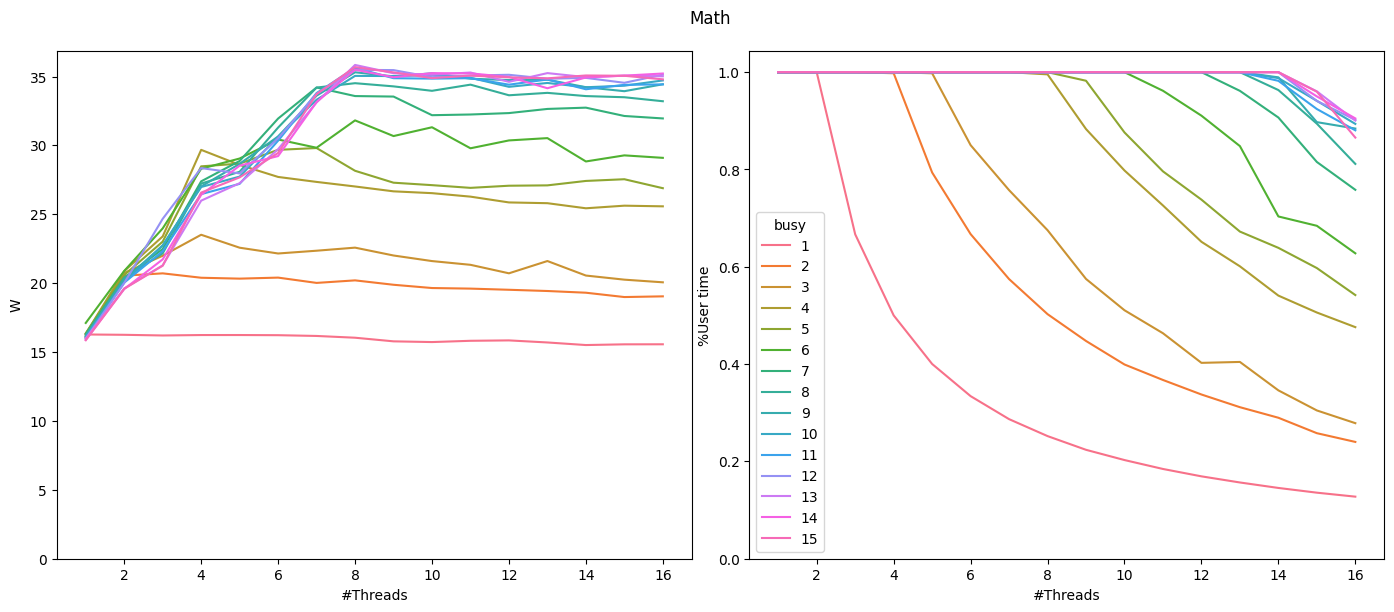

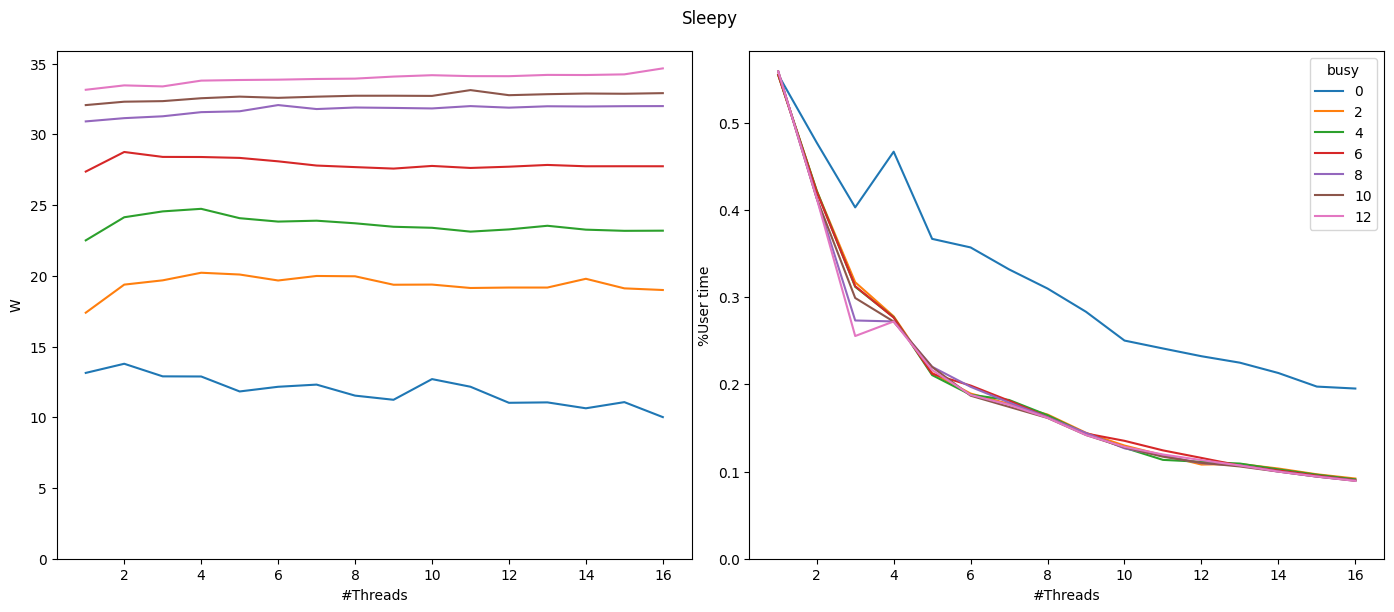

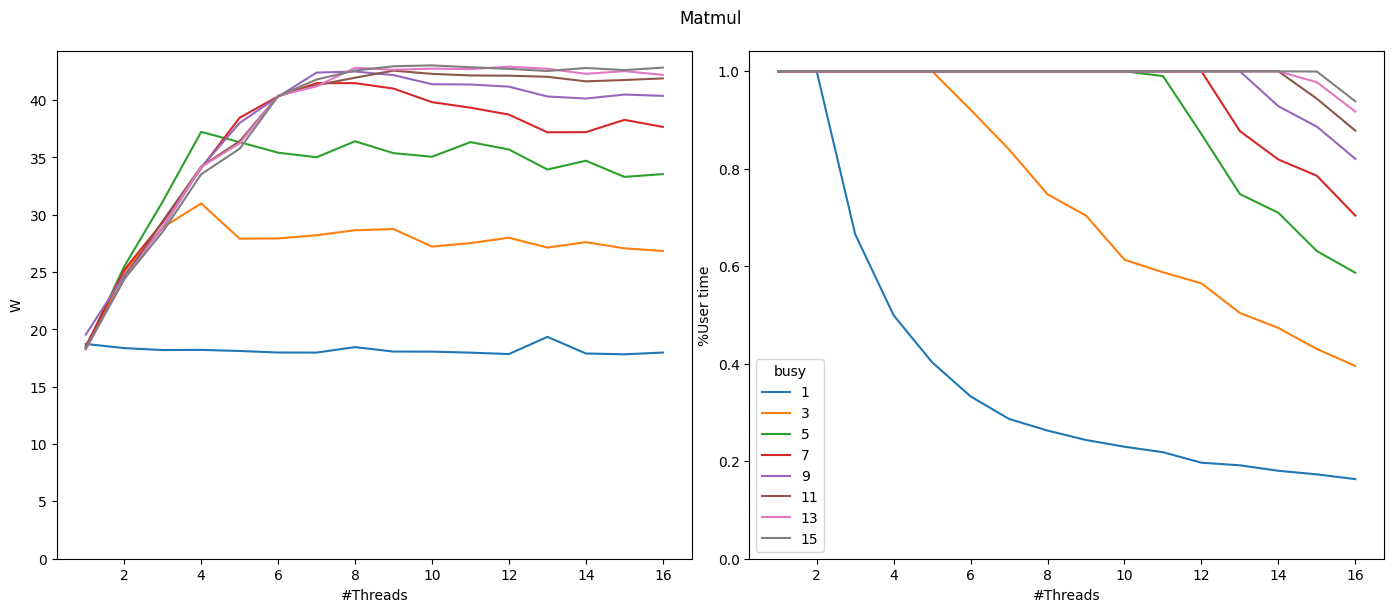

In [25]:
def plot(title, df):
    fig, (ax_power, ax_user) = plt.subplots(1, 2, figsize=(14,6))
    fig.suptitle(title)
    fig.tight_layout()

    # Power
    sns.lineplot(df, x='threads', y='W', hue=df['busy'].astype('category'), ax=ax_power, legend=False)
    ax_power.set_xlabel('#Threads')
    ax_power.set_ylim((0, None))

    # User pct
    sns.lineplot(df, x='threads', y='user-pct', hue=df['busy'].astype('category'), ax=ax_user)
    ax_user.set_xlabel('#Threads')
    ax_user.set_ylabel('%User time')
    ax_user.set_ylim((0, None))

    plt.show()

plot('Math', df_math)
plot('Sleepy', df_sleepy)
plot('Matmul', df_matmul)

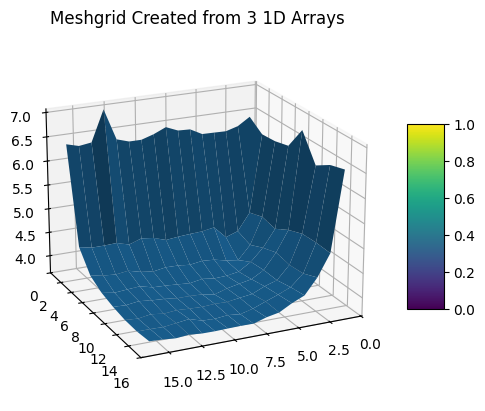

In [108]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np

df = df_matmul

x1 = np.linspace(df['threads'].min(), df['threads'].max(), len(df['threads'].unique()))
y1 = np.linspace(df['busy'].min(), df['busy'].max(), len(df['busy'].unique()))

"""
x, y via meshgrid for vectorized evaluation of
2 scalar/vector fields over 2-D grids, given
one-dimensional coordinate arrays x1, x2,..., xn.
"""

x2, y2 = np.meshgrid(x1, y1)

# Interpolate unstructured D-dimensional data.
z2 = griddata((df['threads'], df['busy']), df['energy'], (x2, y2))

# Ready to plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

surf = ax.plot_surface(x2, y2, z2)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Meshgrid Created from 3 1D Arrays')

ax.view_init(20, 65)

plt.show()